# Head Direction Analyses

Analysis of head direction.

Goal: circular plots of firing rate by head direction.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO
from pingouin import convert_angles, circ_rayleigh

from spiketools.utils import restrict_range
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.utils import make_axes
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.data import plot_polar_hist

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_heading

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Set which example unit to extract
uind = 50

In [8]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

## Load Data

In [9]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [10]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [11]:
# Extract head position data
hd_times = nwbfile.acquisition['position']['head_direction'].timestamps[:]
hd_degrees = nwbfile.acquisition['position']['head_direction'].data[:]

In [12]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [13]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

In [14]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

### Head Direction

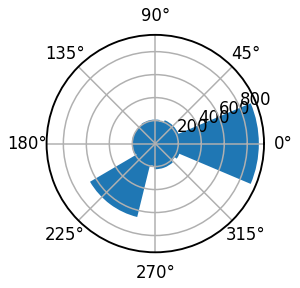

In [15]:
# Plot all head directions
plot_polar_hist(hd_degrees)

In [16]:
# Check for non-uniformity
z_val, p_val = circ_rayleigh(convert_angles(hd_degrees))
z_val, p_val

(559.6556545655576, 1.2417132870322061e-244)

### Head-Direction Related Firing

In [17]:
# Get head direction for each spike
spike_hds = get_spike_heading(spikes, hd_times, hd_degrees)

In [18]:
# Check number of spikes with heading direction
print('{:1.2f}% of spikes ({} / {})'.format(len(spike_hds) / len(spikes) * 100, len(spike_hds), len(spikes)))

29.32% of spikes (1291 / 4403)


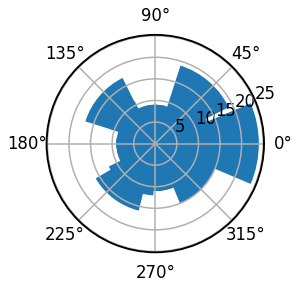

In [19]:
# Plot head direction of spike firing
plot_polar_hist(spike_hds)

In [20]:
# Check for non-uniformity
z_val, p_val = circ_rayleigh(convert_angles(spike_hds))
z_val, p_val

(28.657903741464597, 3.0837818544635783e-13)

#### Compare to shuffles

In [21]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [22]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):    
    spike_hds = get_spike_heading(stimes, hd_times, hd_degrees)
    surrs[ind] = circ_rayleigh(convert_angles(spike_hds))[0]

In [23]:
# Compute the empirical p-value & z-score based on surrogates
surr_p_val = compute_empirical_pvalue(z_val, surrs)
z_score = zscore_to_surrogates(z_val, surrs)

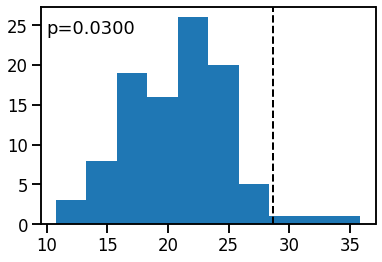

In [24]:
# Plot distribution of surrogates with measured empirical value
plot_surrogates(surrs, z_val, surr_p_val)

## All Cells

In [25]:
# # Examine head-direction related firing across all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep, subplot_kw={'projection': 'polar'}, hspace=0.5)):
    
#     spikes = restrict_range(nwbfile.units.get_unit_spike_times(ii), st, en)
#     spike_hds = get_spike_heading(spikes, hd_times, hd_degrees)
    
#     if len(spike_hds) == 0: continue
    
#     # Compute head direction on real data
#     z_val, p_val = circ_rayleigh(convert_angles(spike_hds))
    
#     # Compute measures on surrogates
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)
#     surrs = np.zeros(n_surrogates)
    
#     for ind, stimes in enumerate(times_shuffle):    
#         spike_hds = get_spike_heading(stimes, hd_times, hd_degrees)
#         surrs[ind] = circ_rayleigh(convert_angles(spike_hds))[0]
        
#     # Compute the empirical p & z-value
#     surr_p_val = compute_empirical_pvalue(z_val, surrs)
#     z_score = zscore_to_surrogates(z_val, surrs)
    
#     plot_polar_hist(spike_hds, ax=ax)
#     title = 'U{} ({:d} spikes): \n z-{:1.2f}, p-{:1.2f}'.format(\
#         ii, len(spike_hds), z_score, surr_p_val)
#     color = 'red' if surr_p_val < 0.05 else 'black'
#     ax.set_title(title, color=color, fontdict={'fontsize' : 14})
    
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])